In this notebook, I will use XGBoost to create a pricing model that can enable us estimate the price range of a shipment, given a set of features

In [101]:
# importing libaries
import pandas as pd
import numpy as np 
from sklearn.metrics import mean_squared_error as mse, r2_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline



In [102]:
# assigning file path to variable
data = r"clean_data.csv"

In [103]:
# loading data to dataframe
clean_df = pd.read_csv(data)

In [104]:
#checking for null values
clean_df.isna().sum()

carrier_number                     0
shipment_number                    0
shipment_date                      0
delivery_date                      0
delivery_reliability               0
feedback_reliability               0
non_conformance_count              0
transport_mode                     0
cost_usd                           0
region                             0
origin_country                     0
origin_postal_code                 0
destination_country                0
destination_postal_code            0
distance_km                        0
lead_time_days                     0
co2_emission_kg                    0
shipment_weight_kg                 0
first_carrier_name                 0
carrier_number_name                0
year_month                         0
price_per_distance                 0
origin_postal_code_2_digit         0
destination_postal_code_2_digit    0
lane                               0
country_lane                       0
dtype: int64

In [105]:
# dF info
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14923 entries, 0 to 14922
Data columns (total 26 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   carrier_number                   14923 non-null  object 
 1   shipment_number                  14923 non-null  object 
 2   shipment_date                    14923 non-null  object 
 3   delivery_date                    14923 non-null  object 
 4   delivery_reliability             14923 non-null  int64  
 5   feedback_reliability             14923 non-null  int64  
 6   non_conformance_count            14923 non-null  int64  
 7   transport_mode                   14923 non-null  object 
 8   cost_usd                         14923 non-null  float64
 9   region                           14923 non-null  object 
 10  origin_country                   14923 non-null  object 
 11  origin_postal_code               14923 non-null  int64  
 12  destination_countr

In [106]:
# converting useful columns to string type
clean_df[['origin_postal_code_2_digit','destination_postal_code_2_digit' ]] = clean_df[['origin_postal_code_2_digit','destination_postal_code_2_digit' ]].astype(str)

In [107]:
#spot check
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14923 entries, 0 to 14922
Data columns (total 26 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   carrier_number                   14923 non-null  object 
 1   shipment_number                  14923 non-null  object 
 2   shipment_date                    14923 non-null  object 
 3   delivery_date                    14923 non-null  object 
 4   delivery_reliability             14923 non-null  int64  
 5   feedback_reliability             14923 non-null  int64  
 6   non_conformance_count            14923 non-null  int64  
 7   transport_mode                   14923 non-null  object 
 8   cost_usd                         14923 non-null  float64
 9   region                           14923 non-null  object 
 10  origin_country                   14923 non-null  object 
 11  origin_postal_code               14923 non-null  int64  
 12  destination_countr

Building a Heatmap

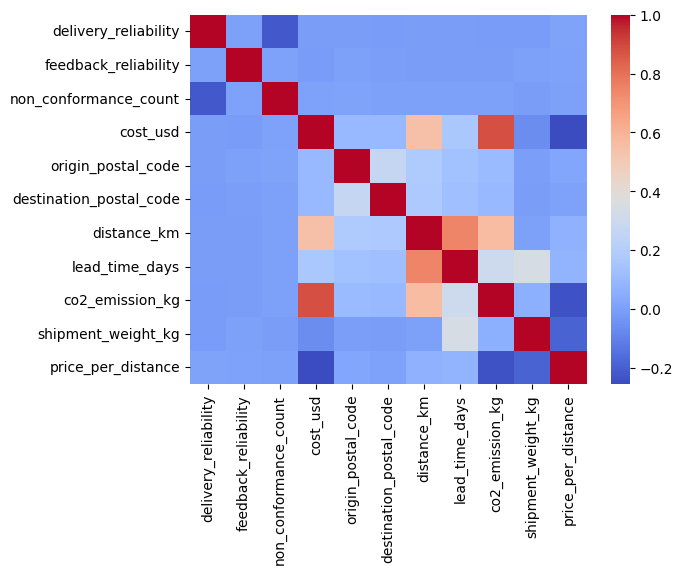

In [108]:
sns.heatmap(clean_df.corr(numeric_only=True), annot=False, cmap="coolwarm")
plt.show()


Based on domain knowledge, and data from the heatmap, I will use the following as the initial features:
* carrier_number_name,
* co2_emission_kg,
* distance_km, 
* transport_mode, 
* cost_usd

In [109]:
# creating a new dataframe for the useful columns
selected_features = clean_df[['carrier_number_name', 'co2_emission_kg', 'distance_km', 'transport_mode', 'cost_usd','origin_country', 'destination_country' ,'origin_postal_code_2_digit','destination_postal_code_2_digit' ]]

In [110]:
#df info
selected_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14923 entries, 0 to 14922
Data columns (total 9 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   carrier_number_name              14923 non-null  object 
 1   co2_emission_kg                  14923 non-null  float64
 2   distance_km                      14923 non-null  float64
 3   transport_mode                   14923 non-null  object 
 4   cost_usd                         14923 non-null  float64
 5   origin_country                   14923 non-null  object 
 6   destination_country              14923 non-null  object 
 7   origin_postal_code_2_digit       14923 non-null  object 
 8   destination_postal_code_2_digit  14923 non-null  object 
dtypes: float64(3), object(6)
memory usage: 1.0+ MB


Splitting Data into training, val and test sets

In [111]:
X_data = selected_features.drop('cost_usd', axis='columns') # features
y_data = selected_features['cost_usd'] #target

In [112]:
# splitting data into training, valuation and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X_data, y_data, train_size=0.8, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, train_size=0.5, random_state=42)

In [113]:
#processing data using pipeline

num_cols = X_train.select_dtypes(include=['float64', 'int64']).columns  # Adjust for continuous
cat_cols = X_train.select_dtypes(include=['object']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), cat_cols)
    ]
)

X_train_enc = preprocessor.fit_transform(X_train)
X_val_enc = preprocessor.transform(X_val)  

In [ ]:
# spot check
X_train_enc.shape

(11938, 8)

In [ ]:
# defining model based on XGBRegressor parameters
model = XGBRegressor(n_estimators=100, early_stopping=50, eval_metric='rmse', max_depth=3, reg_alpha=0.1, random_state=42)


# fitting model to training set
model.fit(X_train_enc, y_train)

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [23:48:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "early_stopping" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'rmse'


In [ ]:
# predicting  training set prices based on Training features
y_train_pred = model.predict(X_train_enc)

In [ ]:
# root mean squared error for training set
rsme = np.sqrt(mse(y_train_pred, y_train))
rsme

np.float64(5834.494036939675)

In [ ]:
# R2 Score
r2_score(y_train_pred, y_train)

0.9093463994643406

In [ ]:
# predicting  validation set prices based on validation features
y_val_pred = model.predict(X_val_enc)

In [ ]:
# root mean squared error for validation set
val_rsme = np.sqrt(mse(y_val_pred, y_val))
val_rsme

np.float64(7435.868763418295)

In [ ]:
# R2 Score
r2_score(y_val_pred, y_val)

0.8488776368941692

In [ ]:
# transforming Test features
X_test_enc = preprocessor.transform(X_test)  

In [ ]:
# predicting  validation set prices based on test features
y_test_pred = model.predict(X_test_enc)

In [ ]:
# root mean squared error for test set
test_rsme = np.sqrt(mse(y_test_pred, y_test))
test_rsme

In [ ]:
# R2 Score
r2_score(y_test_pred, y_test)

Plotting KDE Plots

<Axes: xlabel='cost_usd', ylabel='Density'>

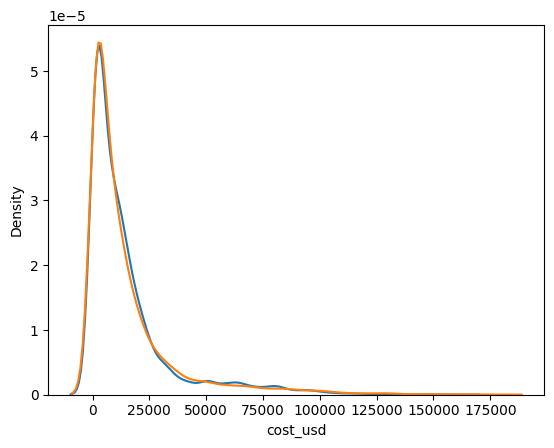

In [ ]:
ax1 = sns.kdeplot(y_train_pred)
sns.kdeplot(y_train, ax=ax1)

<Axes: xlabel='cost_usd', ylabel='Density'>

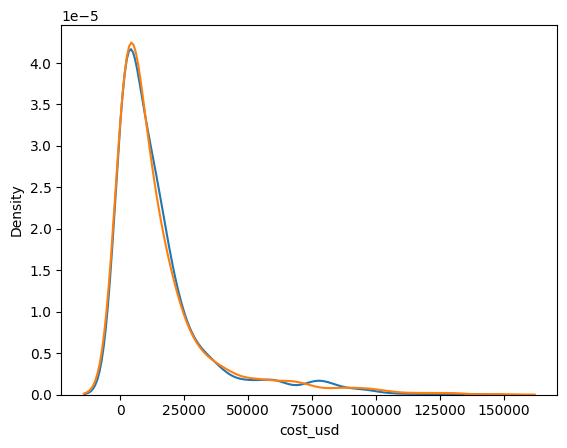

In [123]:
ax1 = sns.kdeplot(y_val_pred)
sns.kdeplot(y_val, ax=ax1)

<Axes: xlabel='cost_usd', ylabel='Density'>

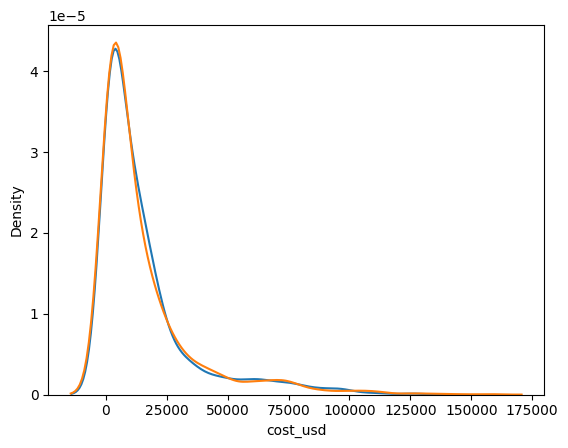

In [129]:
ax1 = sns.kdeplot(y_test_pred)
sns.kdeplot(y_test, ax=ax1)

np.float64(7647.732345480941)

0.851160356720099